📌 何をしていたか？ (目的)

01 で収集した data_papers.csv の内容を分析し、データの全体像を把握していました。

特に、後の「正解データ作成」で偏りのないサンプルを選ぶため、被引用数の分布を詳しく調査しました。

✅ どこまで行っているか？ (達成状況)

まず、全データ論文の被引用数の統計量（平均、中央値、パーセンタイルなど）を算出しました。

次に、実験の方針として「被引用数が 2 以上の論文」を分析対象とすることを決定しました。

対象論文の被引用数分布を箱ひげ図などで可視化し、データが極めて偏っていることを確認しました。

その偏りを考慮し、後のサンプリングで使うための 4 つのカテゴリ（2-10, 11-50, 51-150, 151+）を定義しました。

➡️ このノートブックの成果物:

統計的な知見: データの分布特性の理解。

サンプリング戦略: 正解データ作成のための、層化ランダムサンプリングを行うという明確な方針決定。


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# グラフのスタイルを設定
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 7) # グラフのデフォルトサイズを設定

# --- 設定項目 ---
DATA_DIR = '../data/processed'
DATA_FILE = os.path.join(DATA_DIR, 'data_papers.csv')

# --- データ読み込み ---
try:
    df = pd.read_csv(DATA_FILE)
    print(f"'{DATA_FILE}' を正常に読み込みました。")
    print(f"データ論文の総数: {len(df)}件")

    # citedby_count列を数値型に変換（エラーはNaNにし、その後0で埋める）
    df['citedby_count'] = pd.to_numeric(df['citedby_count'], errors='coerce').fillna(0)

except FileNotFoundError:
    print(f"エラー: '{DATA_FILE}' が見つかりません。")
    print("先に `01_collect_data_papers.ipynb` を実行してください。")

'../data/processed\data_papers.csv' を正常に読み込みました。
データ論文の総数: 19236件


In [2]:
# データが正常に読み込めた場合のみ実行
if 'df' in locals():
    print("--- 被引用数の基本統計量 ---")
    # .describe()で統計量を表示。パーセンタイルも指定して分布を詳しく見る
    print(df['citedby_count'].describe(percentiles=[.25, .5, .75, .9, .95, .99]))

--- 被引用数の基本統計量 ---
count    19236.000000
mean         9.951497
std         46.575116
min          0.000000
25%          1.000000
50%          3.000000
75%          8.000000
90%         20.000000
95%         35.000000
99%         98.650000
max       3110.000000
Name: citedby_count, dtype: float64


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# グラフのスタイルを設定
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 7) # グラフのデフォルトサイズを設定

# --- 設定項目 ---
DATA_DIR = '../data/processed'
DATA_FILE = os.path.join(DATA_DIR, 'data_papers.csv')

# --- データ読み込み ---
try:
    df_original = pd.read_csv(DATA_FILE)
    print(f"'{DATA_FILE}' を正常に読み込みました。")
    print(f"元のデータ論文の総数: {len(df_original)}件")

    # citedby_count列を数値型に変換
    df_original['citedby_count'] = pd.to_numeric(df_original['citedby_count'], errors='coerce').fillna(0)

    # --- 【変更点】被引用数が2以上のデータに絞り込む ---
    df = df_original[df_original['citedby_count'] >= 2].copy()
    print(f"被引用数が2以上のデータ論文の数: {len(df)}件")

except FileNotFoundError:
    print(f"エラー: '{DATA_FILE}' が見つかりません。")

'../data/processed\data_papers.csv' を正常に読み込みました。
元のデータ論文の総数: 19236件
被引用数が2以上のデータ論文の数: 12809件


In [4]:
# データが正常に処理できた場合のみ実行
if 'df' in locals() and not df.empty:
    print("\n--- 被引用数（2以上）の基本統計量 ---")
    print(df['citedby_count'].describe(percentiles=[.25, .5, .75, .9, .95, .99]))
else:
    print("\n表示対象のデータがありません。")


--- 被引用数（2以上）の基本統計量 ---
count    12809.000000
mean        14.737060
std         56.471994
min          2.000000
25%          3.000000
50%          6.000000
75%         13.000000
90%         27.000000
95%         46.000000
99%        125.000000
max       3110.000000
Name: citedby_count, dtype: float64


In [5]:
# df_originalから、被引用数が2以上のデータを抽出したものを df とする
df = df_original[df_original['citedby_count'] >= 2].copy()

if not df.empty:
    # 上記の分析に基づいた、具体的な区切り値を設定
    bins = [
        1,           # 2から始まるための下限
        10,          # 75パーセンタイル(13)より少し下のキリの良い数字
        50,          # 95パーセンタイル(46)より少し上のキリの良い数字
        150,         # 99パーセンタイル(125)より少し上のキリの良い数字
        float('inf') # 151以上はすべて
    ]

    # 各カテゴリのラベルを設定
    labels = [
        '2-10 (Low)',
        '11-50 (Medium)',
        '51-150 (High)',
        '151+ (Top Tier)'
    ]

    # 新しいカテゴリ列を作成
    df['citation_category'] = pd.cut(df['citedby_count'], bins=bins, labels=labels, right=True)

    print("--- カテゴリごとの論文数 ---")
    print(df['citation_category'].value_counts().sort_index())

    # この後、この'citation_category'列を基準に層化サンプリングを実行します
else:
    print("対象となるデータがありません。")

--- カテゴリごとの論文数 ---
citation_category
2-10 (Low)         8896
11-50 (Medium)     3346
51-150 (High)       468
151+ (Top Tier)      99
Name: count, dtype: int64


c:\Users\kurokawa\Desktop\DataUsageValidator\DataUsageValidator\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 34987 (\N{CJK UNIFIED IDEOGRAPH-88AB}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\kurokawa\Desktop\DataUsageValidator\DataUsageValidator\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 24341 (\N{CJK UNIFIED IDEOGRAPH-5F15}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\kurokawa\Desktop\DataUsageValidator\DataUsageValidator\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 29992 (\N{CJK UNIFIED IDEOGRAPH-7528}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\kurokawa\Desktop\DataUsageValidator\DataUsageValidator\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\kurokawa\Desktop\DataUs

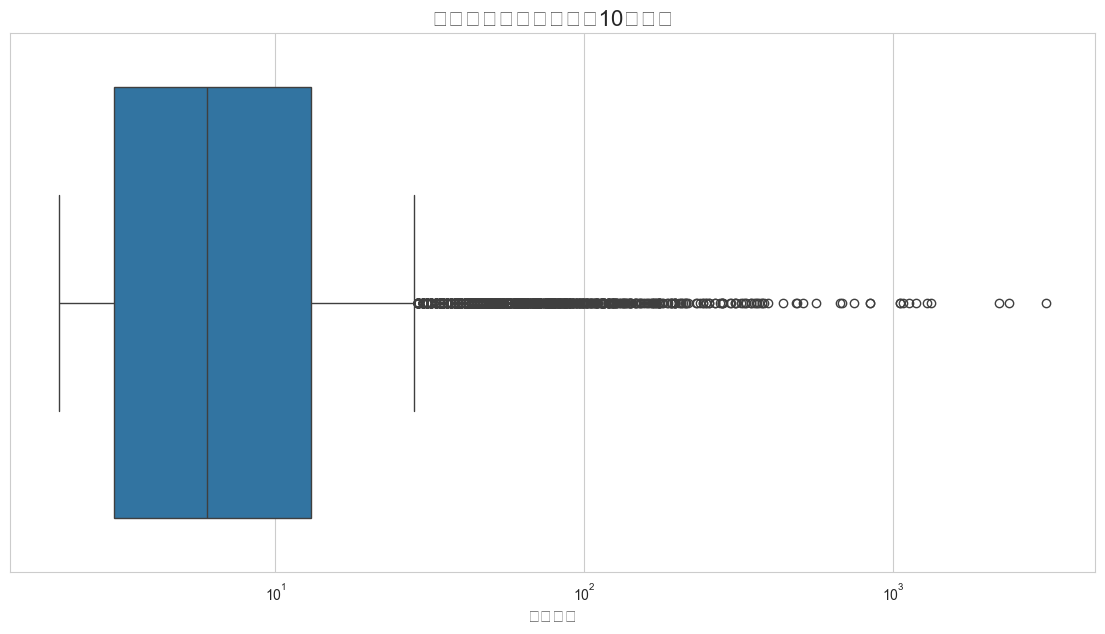

In [6]:
if 'df' in locals() and not df.empty:
    plt.figure(figsize=(14, 7))
    sns.boxplot(x=df['citedby_count'])
    plt.title('被引用数の箱ひげ図（10以上）', fontsize=16)
    plt.xlabel('被引用数', fontsize=12)
    # x軸も対数スケールにすると、外れ値の分布がより見やすくなる
    plt.xscale('log')
    plt.show()

In [7]:
# (前のセルの df (被引用数>=10) を使用)

if 'df' in locals() and not df.empty:
    print("--- 被引用数（10以上）の詳細な分布 ---")
    
    # 25%区切りに加え、90%, 95%, 99%の位置の引用数も確認する
    print(df['citedby_count'].describe(percentiles=[.25, .5, .75, .90, .95, .99]))

--- 被引用数（10以上）の詳細な分布 ---
count    12809.000000
mean        14.737060
std         56.471994
min          2.000000
25%          3.000000
50%          6.000000
75%         13.000000
90%         27.000000
95%         46.000000
99%        125.000000
max       3110.000000
Name: citedby_count, dtype: float64
